In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import pybedtools
import csv
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2025-02-17 16:30:38.235206: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-17 16:30:38.235271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-17 16:30:38.236506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 16:30:38.244607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 16:30:39.792003: W tensorflow/compiler/tf2

In [ ]:
#Model configuration

params_file = 'params.json'
targets_file = 'targets_rna3_only.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 4       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Remove cropping
##params_model['trunk'][-1]['cropping'] = 0

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [5]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = 'hg38/genes/gencode41/gencode41_basic_nort_protein.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
apa_df = pd.read_csv('hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 114605
len(apa_df_intron) = 83473
len(tss_df) = 116649


In [6]:
#Get reference/alternate sequence for variant, and annotations for target gene

search_gene = 'ENSG00000111452'

center_pos = 130981411

chrom = 'chr12'
poses = [130981411]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

load_isoforms = True

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    g_start, g_end = gene.span()
    mid = (g_start + g_end) // 2
    start = mid - seq_len // 2
    end = mid + seq_len // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = sorted(list(set([overlap[3] for overlap in bedt_span.intersect(seq_bedt, wo=True) if search_gene not in overlap[3]])))
gene_slices = []
gene_strands = []
for gene_id in gene_ids :
    gene_slices.append(transcriptome.genes[gene_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))
    gene_strands.append(transcriptome.genes[gene_id].strand)

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

def _switch_transcript_id(id_str) :
    return id_str.replace("gene_id", "gene_id_orig").replace("transcript_id", "gene_id")

#Get gene isoforms
isoform_slices = None
if load_isoforms :
    gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['chrom', 'havana_str', 'feature', 'start', 'end', 'feat1', 'strand', 'feat2', 'id_str'])
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains(search_gene)].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("transcript_id")].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['feature'] == 'exon'].copy().reset_index(drop=True)
    
    transcript_ids = gtf_df['id_str'].apply(lambda x: x.split("transcript_id \"")[1].split("\";")[0]).unique().tolist()
    gtf_df['id_str'] = gtf_df['id_str'].apply(_switch_transcript_id)
    
    gtf_df.to_csv('borzoi_gene_isoforms.gtf', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
    
    transcriptome_iso = bgene.Transcriptome('borzoi_gene_isoforms.gtf')
    
    isoform_slices = []
    for transcript_id in transcript_ids :
        isoform_slices.append(transcriptome_iso.genes[transcript_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))


2025-02-17 16:32:09.227390: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-17 16:32:09.303001: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-17 16:32:09.616870: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-17 16:32:10.792016: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-17 16:32:11.023114: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

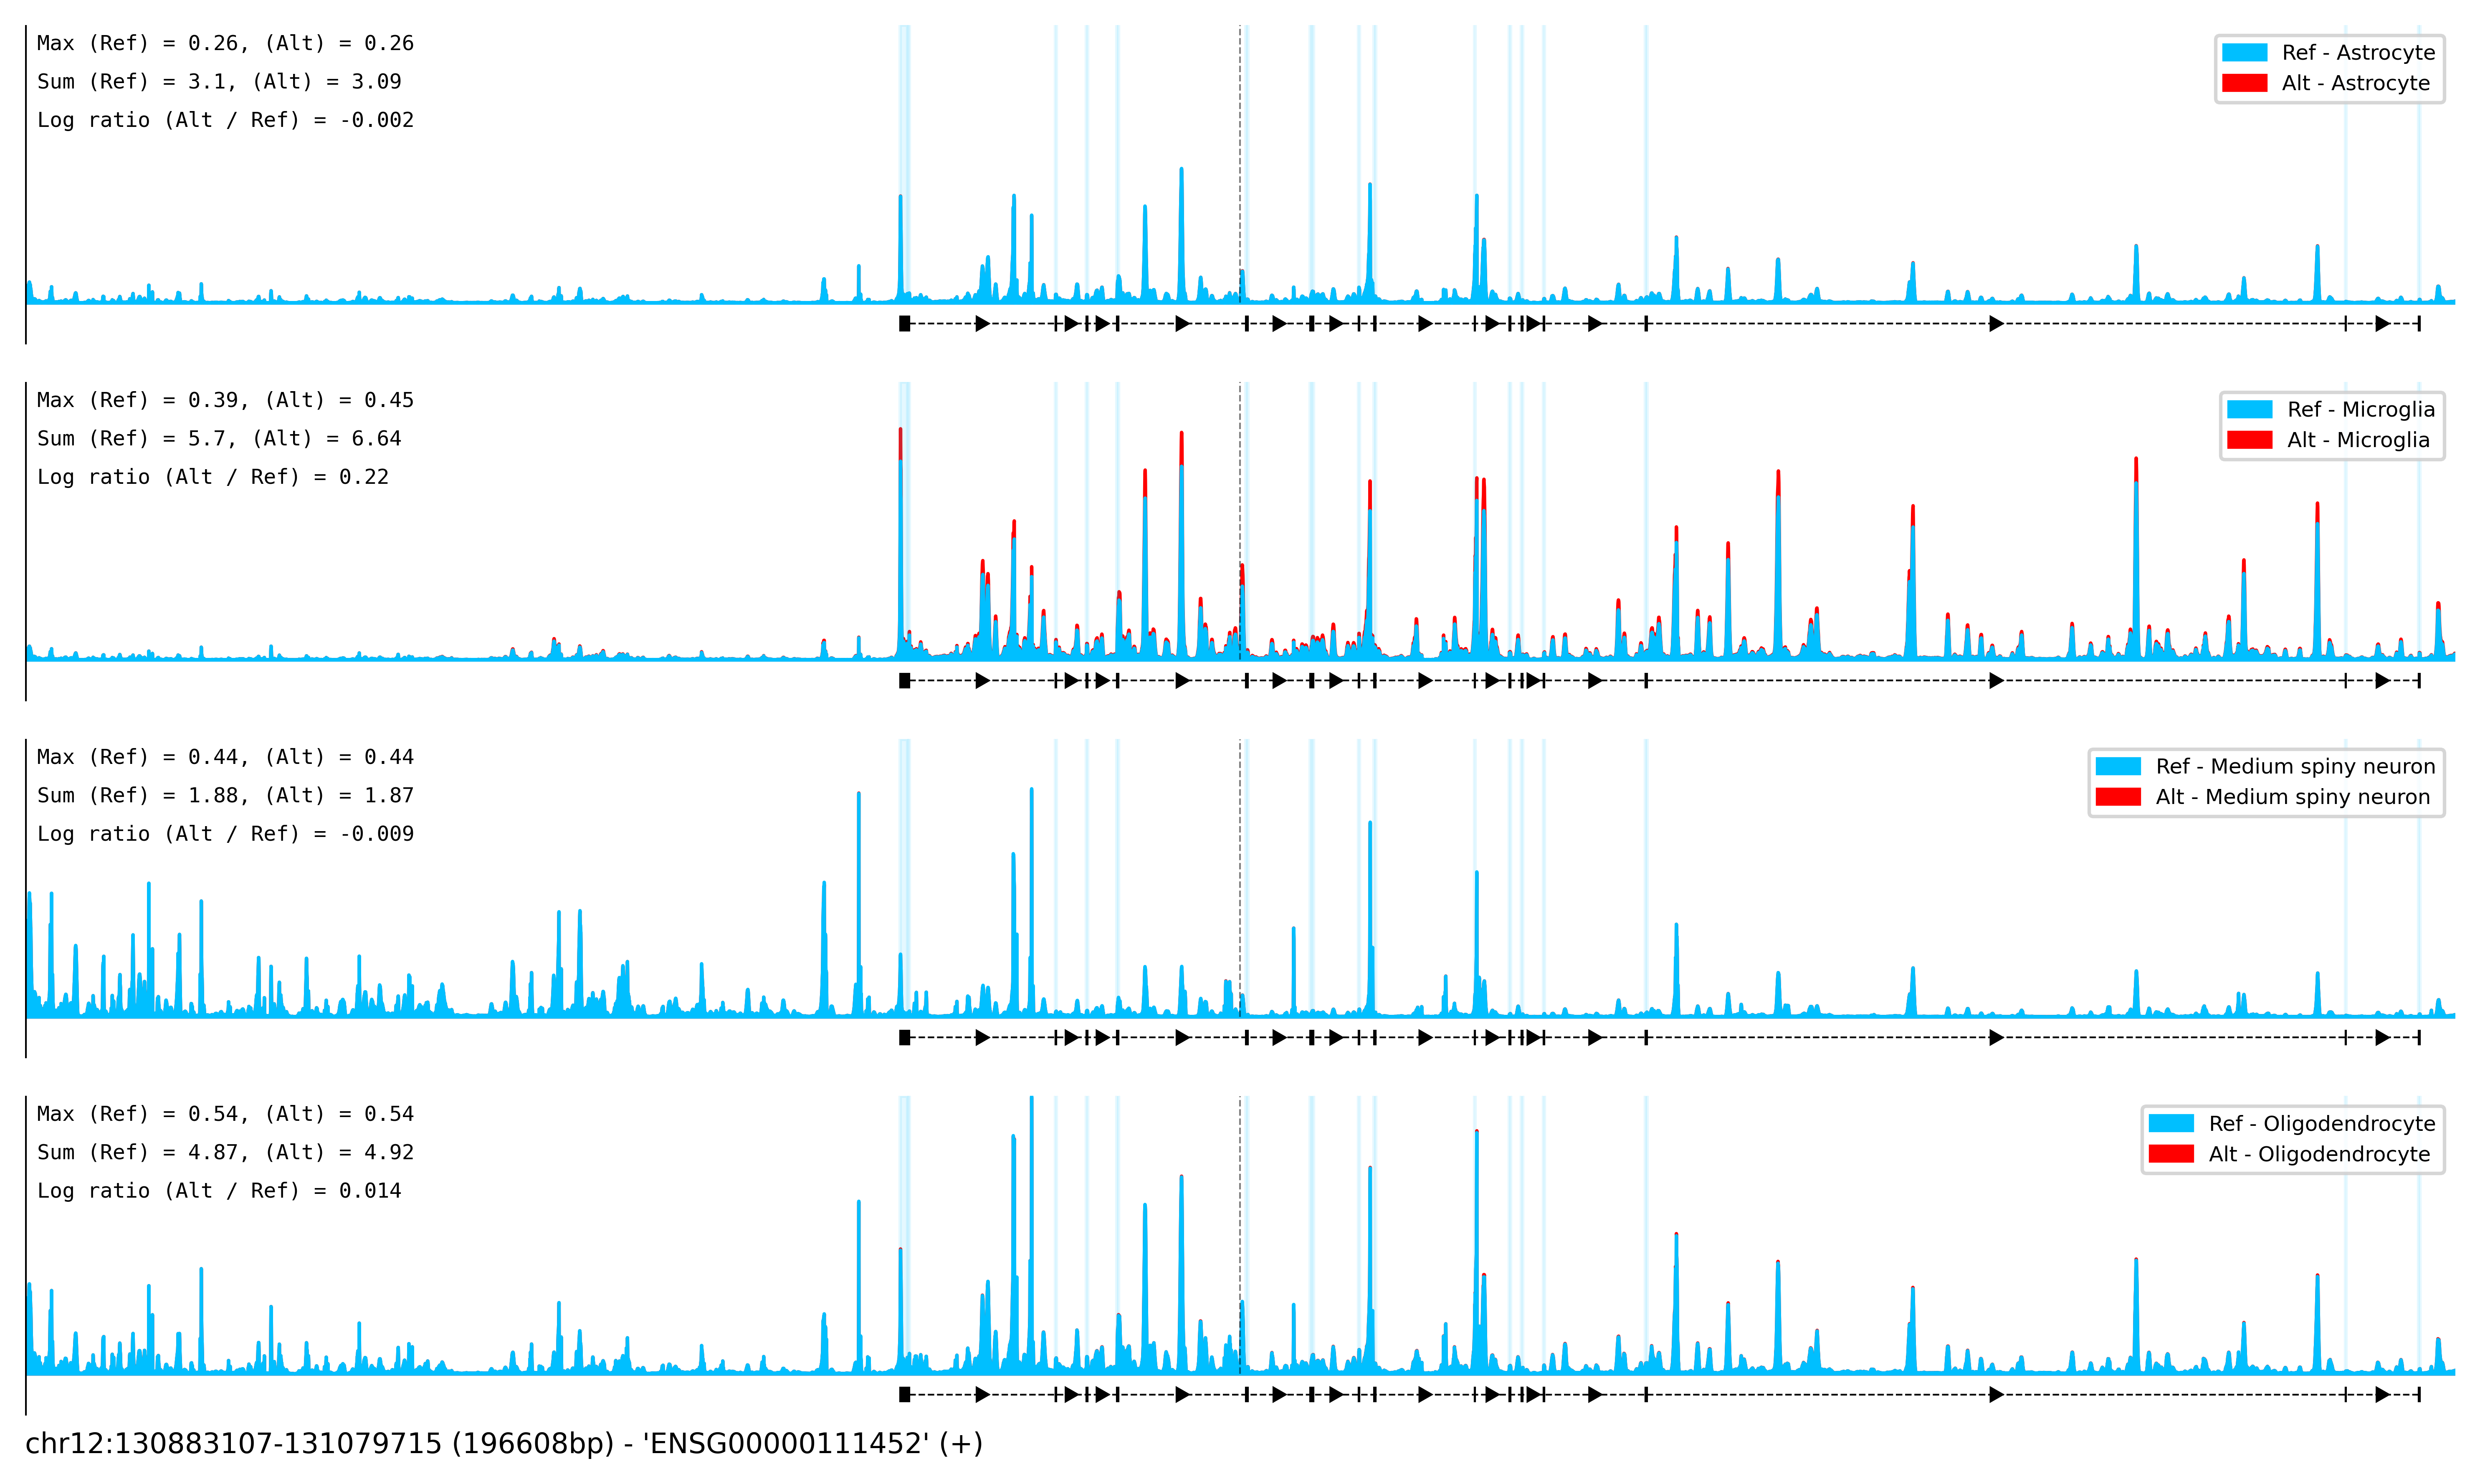

CPU times: user 38.1 s, sys: 2.22 s, total: 40.3 s
Wall time: 52.4 s


In [7]:
%%time
#Predict for chr12_130981411_G_C
# (~6 minutes on CPU w 1 replicate; ~2 minutes on GPU)

save_figs = True
save_suffix = '_chr12_130981411_G_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

highlight_pos_rel = poses[0] - start

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

g_start, g_end = gene.span()
gene_width = (g_end - g_start)

#Visualize coverage tracks
plot_start = 524288//2 - 196608//2
plot_end = 524288//2 + 196608//2
bin_size = 16
pad = 10240

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Astrocyte.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Medium spiny neuron.*')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Oligodendrocyte.*')).values)[0].tolist(),
]

track_names = [
    'Astrocyte',
    'Microglia',
    'Medium spiny neuron',
    'Oligodendrocyte',
]

track_colors = [
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Astrocyte'],
    ['Microglia'],
    ['Medium spiny neuron'],
    ['Oligodendrocyte'],
]

track_labels = [
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
]

track_scale = 1.
track_transform = 3./4.
soft_clip = None

untransform_old = False

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[1, 0],
    pair_alpha=1.,
    log_scale=False,
    same_scale=True,
    highlight_pos_rel=highlight_pos_rel,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=False,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)


In [8]:
%%time
#Get contribution scores (gradient) for Microglia tracks

track_index = np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('.*Microglia.*')).values)[0].tolist()

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=target_index[track_index].tolist(),
    track_scale=1.,
    track_transform=3./4.,
    clip_soft=64.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
    untransform_old=False,
)


1/1 [==============================] - 214s 214s/step
CPU times: user 2h 52min 44s, sys: 11min 13s, total: 3h 3min 57s
Wall time: 3h 10min 54s


--- WT ---


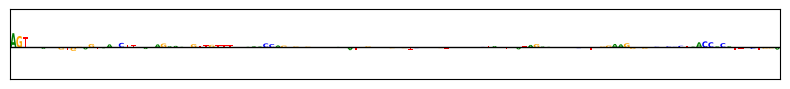

--- Mut ---


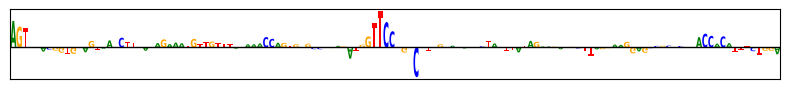

In [9]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_microglia'
)


In [10]:
%%time
#Get contribution scores (ISM) for Microglia tracks

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=track_index,
    track_scale=1.,
    track_transform=3./4.,
    clip_soft=64.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
    untransform_old=False,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 26min 56s, sys: 4min 48s, total: 1h 31min 45s
Wall time: 2h 49min 5s


--- WT ---


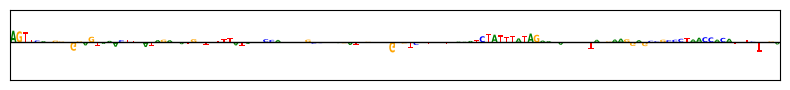

--- Mut ---


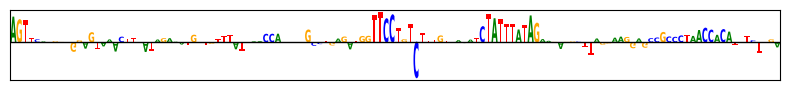

In [11]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=True,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_microglia'
)
